### Deliverables 
1. EDA
2. Data Viz
3. Clustering
4. Silhouette + Inertia
5. 3 different DL models > base
6. 3 DL finetuned models > Keras Tuner
7. 3 ML different ML models > base
8. 3 ML finetuned models > GridsearchCV
9. Feature importance
10. top 10 most common important features on all 3 ML models
11. SHAP Forceplots
12. LIME
13. Saved dataset with the top 10 most common and significant features
14. Select the 2 best models (2 ML)
15. Conclusion and explain why these 2 models and why a DL model if able

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
import missingno as mn

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import NotFittedError

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

#metrics
from sklearn.metrics import(recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc)

#SHAP explainer
import shap

#LIME
import lime
import lime.lime_tabular

#widgets and dispaly
import ipywidgets as widgets
from IPython.display import display

#utilities
import pickle
import os
from tqdm import tqdm

### Business goal
- Determine prices of properties based on the features

### Loading data

In [2]:
file_path = 'data/housing.csv'

df = pd.read_csv(file_path)

df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.20,47.34
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.36,47.51
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.16,47.44
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.37,47.57
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.18,47.73


# 1. EDA


In [3]:
num_record = df.shape[0]
num_features = df.shape[1]
data_types = df.dtypes

print(f'Number of records: {num_record}')
print(f'\nNumber of features {num_features}')
print(f'\nData types: \n{data_types}')

Number of records: 4944

Number of features 22

Data types: 
SalePrice               int64
SqFt1stFloor            int64
SqFtHalfFloor           int64
SqFt2ndFloor            int64
SqFtUpperFloor          int64
SqFtTotLiving           int64
SqFtTotBasement         int64
SqFtFinBasement         int64
SqFtGarageBasement      int64
SqFtGarageAttached      int64
DaylightBasement        int64
SqFtOpenPorch           int64
SqFtEnclosedPorch       int64
SqFtDeck                int64
BrickStone              int64
Bedrooms                int64
BathHalfCount           int64
Bath3qtrCount           int64
BathFullCount           int64
YrBuilt                 int64
Longitude             float64
Latitude              float64
dtype: object


<Axes: >

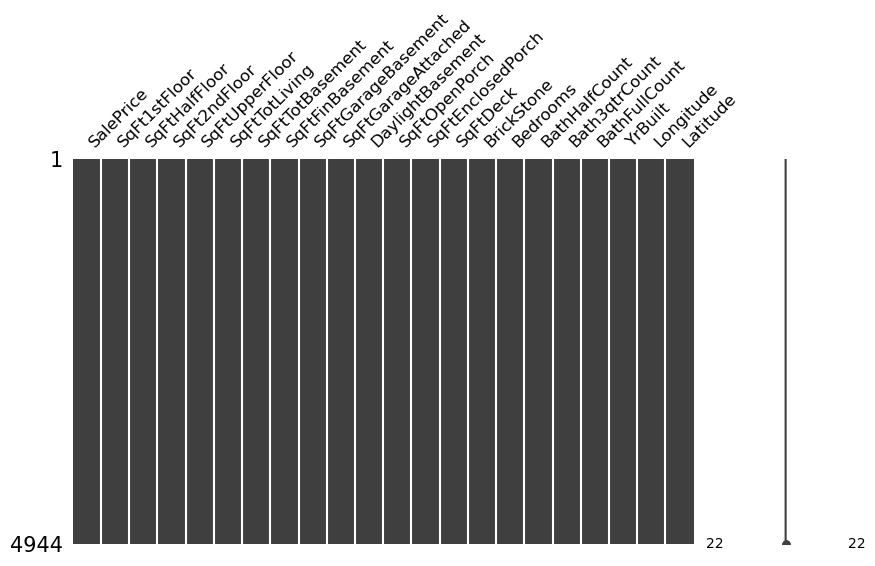

In [4]:
#visualize missing values
mn.matrix(df, figsize=(10,5), width_ratios=(5,1), fontsize=12)

In [5]:
duplicated_rows = df.duplicated().sum()
missing_values = df.isna().sum()

print(f'Number of duplicated rows: {duplicated_rows}')
print(f'\nNumber of missing values: \n{missing_values}')

Number of duplicated rows: 29

Number of missing values: 
SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64


In [6]:
statistics = df.describe()
print(f'\nStatistics: {statistics}')


Statistics:        SalePrice  SqFt1stFloor  SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  \
count    4944.00       4944.00        4944.00       4944.00         4944.00   
mean   664349.73       1175.50          51.76        349.31           26.99   
std    297808.04        446.40         174.46        544.63          115.33   
min     60000.00        260.00           0.00          0.00            0.00   
25%    450000.00        880.00           0.00          0.00            0.00   
50%    630550.00       1170.00           0.00          0.00            0.00   
75%    788612.50       1450.00           0.00        580.00            0.00   
max   1998000.00       3600.00        2000.00       3010.00         1220.00   

       SqFtTotLiving  SqFtTotBasement  SqFtFinBasement  SqFtGarageBasement  \
count        4944.00          4944.00          4944.00             4944.00   
mean         1935.21           595.07           334.27              102.42   
std           764.89           567.18    

In [7]:
def check_column_values(df):
    for column in df.columns:
        print(f'Unique Values in {column} column:')
        print(df[column].unique())
        print('\n')

check_column_values(df)

Unique Values in SalePrice column:
[ 400000  474250  667950 ...  934939  442000 1214950]


Unique Values in SqFt1stFloor column:
[1590 1390 1010  660 2310 1330 1420 1020 1120  770 1060 1730 1450  850
 1280 1110 1090 1820  980 1380 1130  500  360  430  730 1320 1710 1025
 1660 1500 1860  840 1650  960 1180 1230 1480 1430  920 2380  700  950
 1410 1140  900 1490  790  420 1560 1740 1300 1400 1053 1220 1100 1150
  690 1561 1250  810 1270 1210  880 1310  640 1030 1190  600 1050 1200
 1800  610  410  511  440 1840  800  830  890 1370  820 1260 1340 1711
  670  520 1640 1470 1080  984 1160  550 1780 2210  940 1040  990 1940
  910 2330 1920  570 1880 1670 1360 1610 2000 1690  390 1240 1350  710
 1680  860 1000 1193 1620 1580  590  780 1988  330 2790  540  400 1290
  580 1700 2010 1440 1540 1570 2110  480 2390  460 2580 2420 1170 2710
  930 1151 1070 1760 1720 1304 2260 2190 1930 2490 1179 1830  650 1890
  260 2360 1530  380  680  470  750 3030  870 1810  970 2120  620 1550
 1970  441 1900 151

In [8]:
num_cols = df.select_dtypes(include='number')

corr = num_cols.corr()
corr.style.background_gradient(cmap='coolwarm').format('{:.2f}')

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
SalePrice,1.00,0.18,0.10,0.37,0.07,0.51,0.19,0.20,0.02,0.09,0.09,0.21,0.00,0.20,0.08,0.26,0.17,0.19,0.29,0.13,0.07,0.41
SqFt1stFloor,0.18,1.00,-0.01,-0.08,-0.32,0.58,0.21,0.19,0.09,0.39,-0.03,0.19,-0.06,-0.05,0.08,0.45,0.02,0.09,0.19,-0.25,0.40,-0.12
SqFtHalfFloor,0.10,-0.01,1.00,-0.14,-0.04,0.07,0.06,-0.07,-0.08,-0.09,-0.15,0.03,0.03,-0.07,0.08,0.09,-0.01,-0.09,-0.03,-0.30,-0.11,0.07
SqFt2ndFloor,0.37,-0.08,-0.14,1.00,0.11,0.54,-0.30,-0.20,-0.13,0.36,-0.15,0.39,-0.00,-0.00,-0.11,0.30,0.29,0.08,0.50,0.59,0.18,-0.01
SqFtUpperFloor,0.07,-0.32,-0.04,0.11,1.00,-0.06,-0.20,-0.16,-0.06,-0.13,-0.13,-0.06,0.06,0.17,-0.04,-0.13,0.04,0.05,0.01,0.32,-0.17,0.09
SqFtTotLiving,0.51,0.58,0.07,0.54,-0.06,1.00,0.32,0.49,0.07,0.39,0.14,0.37,-0.03,0.12,0.04,0.66,0.25,0.28,0.53,0.24,0.32,-0.02
SqFtTotBasement,0.19,0.21,0.06,-0.30,-0.20,0.32,1.00,0.78,0.49,-0.28,0.55,-0.05,-0.01,0.17,0.17,0.24,-0.00,0.22,0.03,-0.24,-0.07,0.14
SqFtFinBasement,0.20,0.19,-0.07,-0.20,-0.16,0.49,0.78,1.00,0.25,-0.09,0.58,-0.03,-0.01,0.25,0.11,0.32,0.04,0.33,0.12,-0.02,0.03,0.06
SqFtGarageBasement,0.02,0.09,-0.08,-0.13,-0.06,0.07,0.49,0.25,1.00,-0.32,0.38,-0.09,-0.03,0.07,0.04,0.03,0.10,0.19,0.00,0.08,0.03,0.09
SqFtGarageAttached,0.09,0.39,-0.09,0.36,-0.13,0.39,-0.28,-0.09,-0.32,1.00,-0.19,0.28,-0.07,-0.09,-0.06,0.29,0.11,0.03,0.26,0.19,0.44,-0.22


# 2. Data Visualization

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'SqFt1stFloor'}>,
        <Axes: title={'center': 'SqFtHalfFloor'}>,
        <Axes: title={'center': 'SqFt2ndFloor'}>,
        <Axes: title={'center': 'SqFtUpperFloor'}>],
       [<Axes: title={'center': 'SqFtTotLiving'}>,
        <Axes: title={'center': 'SqFtTotBasement'}>,
        <Axes: title={'center': 'SqFtFinBasement'}>,
        <Axes: title={'center': 'SqFtGarageBasement'}>,
        <Axes: title={'center': 'SqFtGarageAttached'}>],
       [<Axes: title={'center': 'DaylightBasement'}>,
        <Axes: title={'center': 'SqFtOpenPorch'}>,
        <Axes: title={'center': 'SqFtEnclosedPorch'}>,
        <Axes: title={'center': 'SqFtDeck'}>,
        <Axes: title={'center': 'BrickStone'}>],
       [<Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'BathHalfCount'}>,
        <Axes: title={'center': 'Bath3qtrCount'}>,
        <Axes: title={'center': 'BathFullCount'}>,
        <Axes: title={'ce

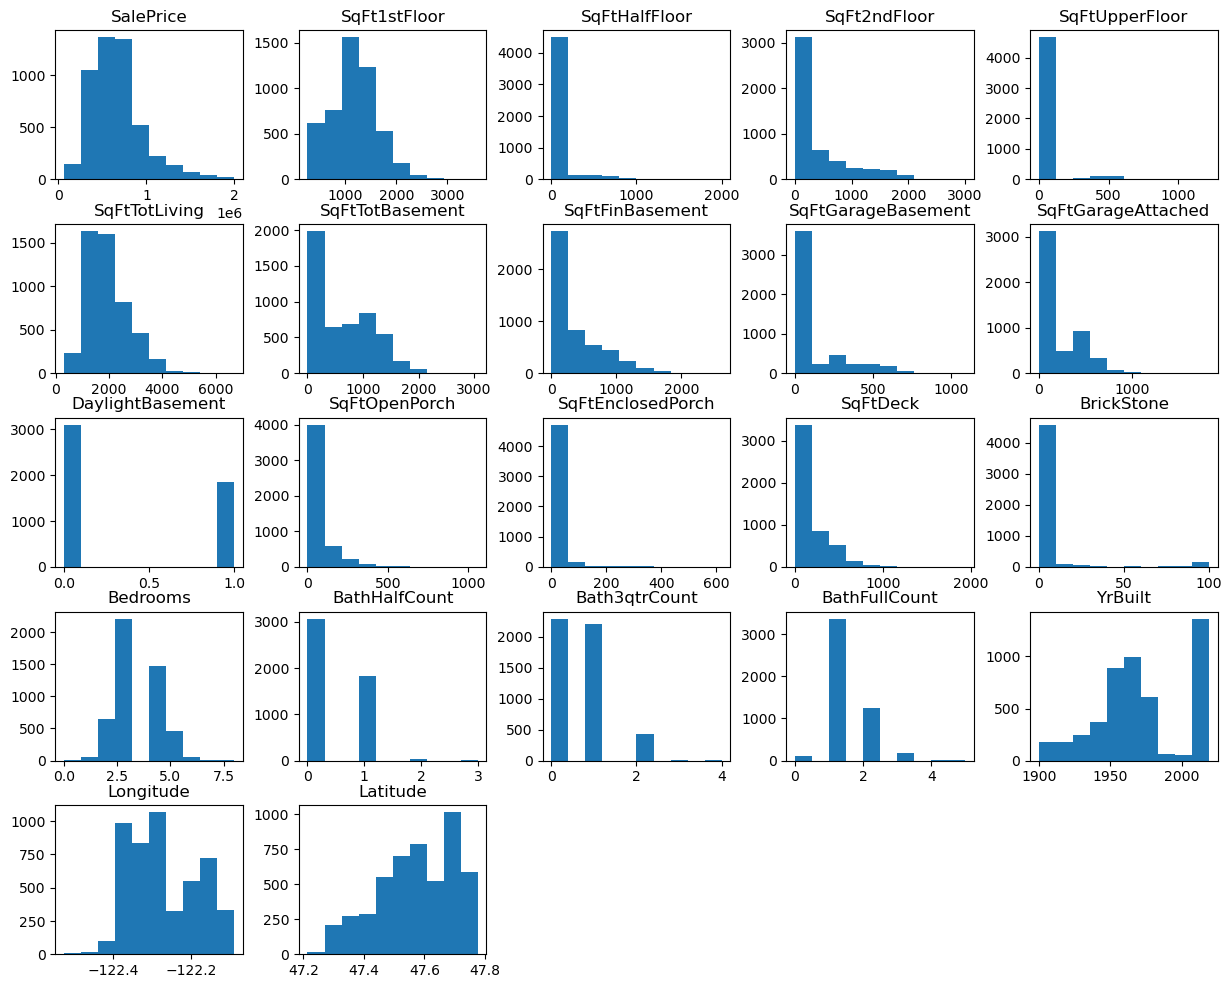

In [9]:
#Data Overview
df.hist(figsize=(15,12), bins=10, grid=False)

In [10]:
df.columns

Index(['SalePrice', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BrickStone',
       'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
       'YrBuilt', 'Longitude', 'Latitude'],
      dtype='object')

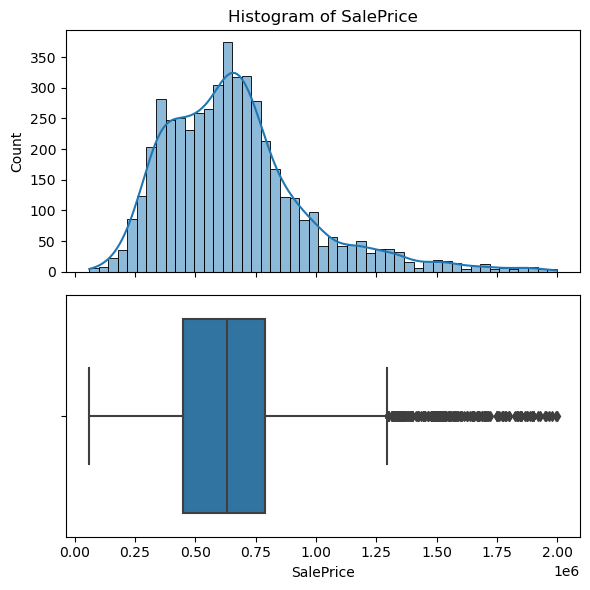

In [11]:
feature = 'SalePrice'

fig, axes = plt.subplots(nrows=2, figsize=(6,6), sharex=True)
sn.histplot(df[feature], bins='auto', kde=True, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title(f'Histogram of {feature}')

sn.boxplot(data=df, x=feature, ax=axes[1])
#remove grids
axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

### Observations
- The distribution of sale prices is right-skewed, meaning that most of the sale prices are concentrated on the lower end, with a long tail extending to the right.
- There is a peak around $500,000, indicating that this price range has the highest frequency of sales.
- The highest frequency of sale prices falls between $400,000 and $600,000, indicating that most houses are sold within this range.

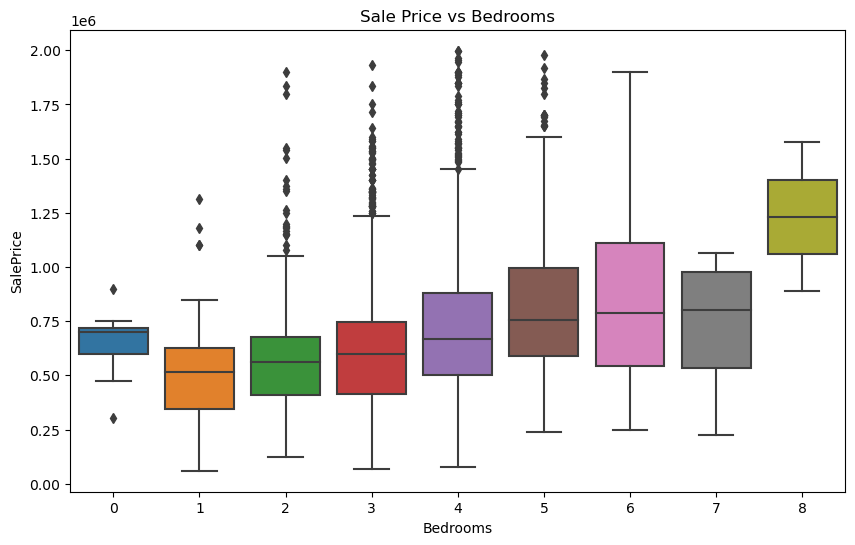

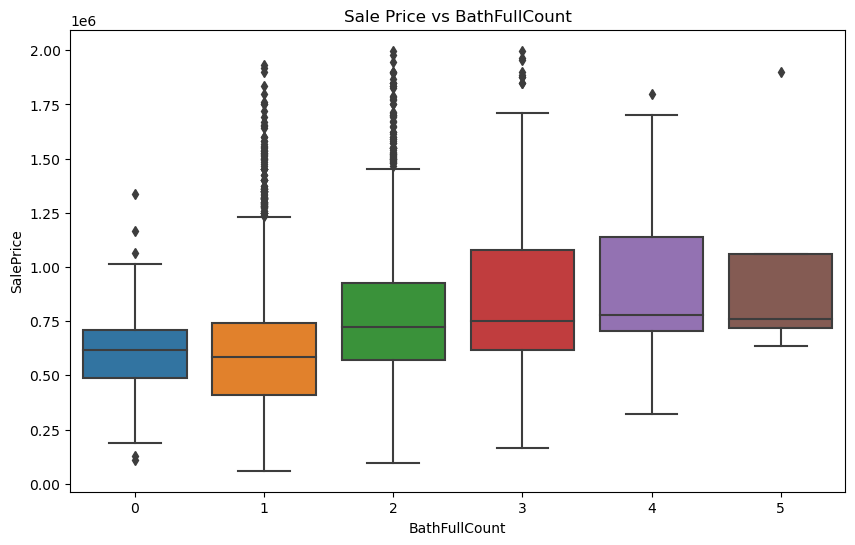

In [12]:
categorical_features = ['Bedrooms', 'BathFullCount']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sn.boxplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'Sale Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

### Observations
*Sale Price vs Bedrooms*
- The highest median sale prices are seen in houses with 8 bedrooms, while the median prices for 5 and 6 bedrooms also tend to be higher.
- Houses with 4 bedrooms show a considerable number of outliers above the upper whisker, indicating some properties are much more expensive than others within this category.

*Sale Price vs Bathrooms*
- As the number of full bathrooms increases from 0 to 3, the sale prices increase notably.
- Houses with 5 full bathrooms have a high median price but a narrow range, suggesting they might be luxury properties with consistent pricing.

# 3. Silhouettes & Inertia

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Clustering and Dimensionality Reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner import HyperParameters as hp

# Metrics
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    silhouette_score
)

from tensorflow.keras.metrics import Recall, Precision

# Progress bars
from tqdm import tqdm, trange
from tqdm.keras import TqdmCallback

#utilities
import pickle
import os

In [14]:
df_copy = df.copy()

def scale_features(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
    return scaled_df

In [15]:
def calculate_kmeans_score(scaled_df, k_range):
    
    inertias = []
    silhouettes = []
    
    for k in trange(k_range.start, k_range.stop): # trange adds a progress bar using tqdm
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        kmeans.fit(scaled_df)
        
        inertias.append(kmeans.inertia_)
        
        # Ensure silhouette score calculation is correct
        if len(set(kmeans.labels_)) > 1: # at least 2 clusters
            silhouettes.append(silhouette_score(scaled_df, kmeans.labels_))
        else:
            silhouettes.append(float('nan'))
            
    return inertias, silhouettes

In [16]:
def plot_kmeans_scores(k_range, inertias, silhouettes):
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Inertia Scores", "Silhouette Scores"))

    # Add Inertia scores trace
    fig.add_trace(go.Scatter(
        x=list(k_range),
        y=inertias,
        mode='lines+markers',
        name='Inertia',
        line=dict(color='blue'),
        marker=dict(color='blue')
    ),row=1, col=1)

    # Add Silhouette scores trace
    fig.add_trace(go.Scatter(
        x=list(k_range),
        y=silhouettes,
        mode='lines+markers',
        name='Silhouettes',
        line=dict(color='red'),
        marker=dict(color='red')
    ),row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text="KMeans Clustering Scores",
        showlegend=False,
        height=500,
        width=1000,
    )

    # Update x and y axis titles
    fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=1)
    fig.update_yaxes(title_text="Inertia", row=1, col=1)
    fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=2)
    fig.update_yaxes(title_text="Silhouette", row=1, col=2)

    fig.show()

In [17]:
scaled_df_copy = scale_features(df_copy)

# Define k_range
k_range = range(2, 10)

# Calculate KMeans scores using the scaled copy of the dataframe
inertias, silhouettes = calculate_kmeans_score(scaled_df_copy, k_range)

# Plot the scores using Plotly
plot_kmeans_scores(k_range, inertias, silhouettes)

100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


### Interpretation of KMeans Clustering Scores
- *Inertia Scores*: Show a decreasing trend with increasing K, as expected. The steep decline up to K=4 or K=5 indicates that these values could be optimal.
- *Silhouette Scores*: Peaks at K=5 and K=9 suggest that these numbers of clusters provide the best-defined clusters. A significant drop at K=7 indicates poor clustering quality.

*Conclusion*
- Considering both inertia and silhouette scores, ``K=5`` seems to be a strong candidate for the optimal number of clusters, as it balances low inertia and high silhouette scores.

# 4. Clustering

In [18]:
def fit_kmeans_and_label_clusters(df, scaled_df, n_clusters=5, n_init=10):
    #create copy of the original df to preserve integrity
    df_copy = df.copy()

    #fit the final model with the specified number of clusters
    kmean_final = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42)
    kmean_final.fit(scaled_df)

    df_copy['Cluster'] = kmean_final.labels_
    cluster_descriptions = df_copy.groupby('Cluster').mean()
    
    return cluster_descriptions

In [19]:
#fit kmeans and label clusters
cluster_descriptions = fit_kmeans_and_label_clusters(df, scaled_df_copy)
cluster_descriptions

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
Cluster,,,,,,,,,,,,,,,,,,,,,
0,800569.38,1308.39,129.22,104.51,10.31,2074.66,1030.47,523.94,135.23,89.59,...,4.77,98.39,92.98,3.22,0.35,0.52,1.18,1947.64,-122.31,47.61
1,697329.68,559.87,6.76,555.49,146.74,1531.81,374.72,267.07,103.23,10.36,...,16.10,297.75,0.00,2.75,0.53,0.91,1.24,2015.96,-122.33,47.62
2,529801.87,1199.17,92.03,67.54,0.00,1435.00,346.77,80.80,25.97,159.11,...,7.88,67.28,0.84,3.03,0.21,0.29,1.10,1947.47,-122.28,47.55
3,700837.24,1411.69,24.28,82.74,0.00,2323.93,1228.91,805.37,243.72,138.65,...,6.05,206.61,1.55,3.83,0.40,0.94,1.32,1965.34,-122.25,47.58
4,870959.46,1372.70,30.67,1400.64,9.24,2959.10,207.03,146.59,28.69,471.03,...,5.04,90.29,0.36,4.23,0.67,0.63,2.05,2003.76,-122.20,47.55


In [20]:
def visualize_clusters_plotly(cluster_descriptions, column, title, ylabel, colors, annotations):
    fig = px.bar(
        cluster_descriptions.reset_index(),
        x='Cluster',
        y=column,
        color='Cluster',
        color_discrete_sequence=colors,
        title=title,
        labels={'Cluster': 'Cluster', column: ylabel}
    )

    fig.update_layout(
        title={'x': 0.5},  # Center the title
        xaxis_title='Cluster',
        yaxis_title=ylabel
    )

    # Add annotations for locations
    for cluster, annotation in annotations.items():
        fig.add_annotation(
            x=cluster,
            y=cluster_descriptions.loc[cluster, column],
            text=annotation,
            showarrow=True,
            arrowhead=1
        )
    
    fig.show()

# Cluster descriptions
annotations = {
    0: "Central Seattle",
    1: "Northwest Seattle",
    2: "Southeast Seattle",
    3: "East/Northeast Seattle",
    4: "Bellevue Area"
}

#visualize Sale Price
visualize_clusters_plotly(
    cluster_descriptions=cluster_descriptions,
    column='SalePrice',
    title='Average Sale Price per Cluster',
    ylabel='Average Sale Price ($)',
    colors=px.colors.qualitative.Plotly,
    annotations=annotations
)

#visualize total living are
visualize_clusters_plotly(
    cluster_descriptions=cluster_descriptions,
    column='SqFtTotLiving',
    title='Average Total Living Area per Cluster',
    ylabel='Total Living Area (sq ft)',
    colors=px.colors.qualitative.Plotly,
    annotations=annotations
)

# Visualize Number of Bedrooms
visualize_clusters_plotly(
    cluster_descriptions=cluster_descriptions,
    column='Bedrooms',
    title="Average Number of Bedrooms per Cluster",
    ylabel="Number of Bedrooms",
    colors=px.colors.qualitative.Plotly,
    annotations=annotations
)


In [21]:
import folium

# Define cluster centers with their average longitude and latitude
cluster_centers = {
    'Cluster 0': {'Longitude': -122.31, 'Latitude': 47.61},
    'Cluster 1': {'Longitude': -122.33, 'Latitude': 47.62},
    'Cluster 2': {'Longitude': -122.28, 'Latitude': 47.55},
    'Cluster 3': {'Longitude': -122.25, 'Latitude': 47.58},
    'Cluster 4': {'Longitude': -122.20, 'Latitude': 47.55}
}

# Create a map centered around Seattle
map_seattle = folium.Map(location=[47.60, -122.33], zoom_start=10)

# Add cluster centers to the map
for cluster, coords in cluster_centers.items():
    folium.Marker(
        location=[coords['Latitude'], coords['Longitude']],
        popup=cluster,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_seattle)

# Display the map
map_seattle

# PCA (Dimensionality Reduction)

In [22]:
# # Data Validation

# #identify target y and features x for modeling
# y=df['SalePrice']
# X=df.drop(columns=['SalePrice'])

# #split the data
# # X_train, X_test, y_test, y_train = train_test_split(X, y, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # wrong sequence y_test, y_train

my code

In [23]:
# Identify target y and features X for modeling
y = df_copy['SalePrice'] 
X = df_copy.drop(columns=['SalePrice'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
# #create a function to scale and plot PCa
# def scale_plot_pca(X_train, X_test, n_components=None):
#     scaler = StandardScaler()

#     #scale the dataset
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.fit_transform(X_train)
    
#     #instantiate and fit the pca model
#     pca = PCA(n_components=n_components)
#     pca.fit(X_train_scaled)

#     #plot the explained variance ratio for each principal component
#     fig = go.Figure(data=[
#         go.Scatter(
#             x=list(range(1, len(pca.explained_variance_ratio_) + 1)),
#             y=pca.explained_variance_ratio_,
#             mode='lines+markers',
#             marker=dict(color='blue'),
#             line=dict(color='blue')
#         )
#     ])
#     fig.update_layout(
#         title='Explained Variance by Principal Component',
#         xaxis_title='Number of Components',
#         yaxis_title='Explained Variance Ratio',
#         xaxis=dict(tickmode='array', tickvals=list(range(1, len(pca.explained_variance_ratio_) + 1))),
#         yaxis=dict(range=[0, max(pca.explained_variance_ratio_) * 1.1]),
#         showlegend=False
#     )
#     fig.show()
#     return X_train_scaled, X_test_scaled, pca

# Create a function to scale and plot PCA
def scale_and_plot_pca(X_train, X_test, n_components=None):

    # Instantiate the StandardScaler
    scaler = StandardScaler()

    # Scale the datasets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Instantiate and fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)

    # Plot the explained variance ratio for each principal component using Plotly
    fig = go.Figure(data=[
        go.Scatter(
            x=list(range(1, len(pca.explained_variance_ratio_) + 1)),
            y=pca.explained_variance_ratio_,
            mode='lines+markers',
            marker=dict(color='blue'),
            line=dict(color='blue')
        )
    ])
    fig.update_layout(
        title='Explained Variance by Principal Components',
        xaxis_title='Number of Components',
        yaxis_title='Explained Variance Ratio',
        xaxis=dict(tickmode='array', tickvals=list(range(1, len(pca.explained_variance_ratio_) + 1))),
        yaxis=dict(range=[0, max(pca.explained_variance_ratio_) * 1.1]),
        showlegend=False
    )
    fig.show()

    return X_train_scaled, X_test_scaled, pca

In [25]:
# call the function
# X_train_scaled, X_test_scaled, pca_model = scale_plot_pca(X_train, X_test)
X_train_scaled, X_test_scaled, pca_model = scale_and_plot_pca(X_train, X_test)

### Interpretation 
- ``First Few Components``: The first 3-4 components explain a substantial amount of the variance, roughly 50% in total.
- ``Diminishing Returns``: After the first few components, each additional component explains progressively less variance. By the time we reach the 10th component, each new component explains less than 5% of the variance.
- ``Elbow Point``: There is an "elbow" in the plot around the 3rd or 4th component, indicating that adding more components beyond this point results in a smaller increase in explained variance. This is often used as a heuristic to select the number of components to keep.


In [26]:
#cumulative explained variance
def cumulative_explained_variance(pca, threshold=0.90):

    #calculate cumulative explained variance ratio
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    #determine number of components for a given threshold
    optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    #plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(1, len(cumulative_explained_variance) + 1)),
        y=cumulative_explained_variance,
        mode='lines+markers',
        line=dict(color='blue'),
        marker=dict(color='blue')
    ))

    fig.add_hline(y=threshold, line=dict(color='red', dash='dash'), annotation_text=f'{int(threshold * 100)}% threshold', annotation_position='bottom right')

    #update layout
    fig.update_layout(
        title_text='Cumulative Explained Variance by Principal Components',
        xaxis_title='Number of Components',
        yaxis_title='Cumulative Explained Variance',
        showlegend=False
    )

    fig.show()
    print(f'Number of components for {int(threshold * 100)}% explained variance: {optimal_components}')
          
    return optimal_components

In [27]:
pca = PCA().fit(X_train_scaled)
optimal_components = cumulative_explained_variance(pca, threshold=0.95)

Number of components for 95% explained variance: 16


# 5. Deep Learning

In [28]:
def extract_nn_config(model):
    layers_info = []
    if "Sequential" in str(model):  # Handle Sequential models without input layer
        first_layer= model.layers[0]
        layers_info.append({
            "name": "input",
            "in": int(first_layer.input.shape[-1]),
            "neurons": 0,
            "out": int(first_layer.input.shape[-1]),
            "activation": None,
            "params": 0,
            "bias": 0
        })
    for layer in model.layers:
        try:
            layer_info={
                "name": layer.name,
                "in": int(layer.input.shape[-1]),
                "neurons": getattr(layer, 'units', 0),
                "out": int(layer.output.shape[-1]),
                "activation": layer.get_config().get("activation", None),
                "params": layer.count_params(),
                "bias": layer.get_weights()[1].shape[0] if layer.get_weights() else 0
            }
        except:
            layer_info={
                "name": layer.name,
                "in": int(layer.input.shape[-1]),
                "neurons": 0,
                "out": int(layer.output.shape[-1]),
                "activation": None,
                "params": 0,
                "bias": 0
            }
        layers_info.append(layer_info)
    return layers_info

def visualize_nn(model, description=False, figsize=(10, 8)):
    layers_info = extract_nn_config(model)
    layer_sizes = [layer["out"] for layer in layers_info]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right - left) / (len(layer_sizes) - 1)
    y_space = (top - bottom) / max(layer_sizes)
    p = 0.025

    for i, size in enumerate(layer_sizes):
        top_on_layer = y_space * (size - 1) / 2 + (top + bottom) / 2
        color = "red" if (layers_info[i]['neurons'] == 0) and (i > 0) else "blue" if i not in [0, len(layer_sizes) - 1] else "green"
        
        if description:
            plt.text(left + i * x_space, top, layers_info[i]["name"].upper(), fontsize=10, color=color)
            if layers_info[i]['activation']:
                plt.text(left + i * x_space, top - p, layers_info[i]['activation'], fontsize=10, color=color)
                plt.text(left + i * x_space, top - 2 * p, f"Σ{layers_info[i]['in']}[X*w]+b", fontsize=10, color=color)
                plt.text(left + i * x_space, top - 3 * p, f") = {layers_info[i]['neurons']} {'Y' if i == len(layer_sizes) - 1 else 'out'}", fontsize=10, color=color)

        for j in range(size):
            circle = plt.Circle((left + i * x_space, top_on_layer - j * y_space), radius=y_space / 4, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            if i == 0:
                plt.text(left - 4 * p, top_on_layer - j * y_space, f'$X_{{{j + 1}}}$', fontsize=10)
            elif i == len(layer_sizes) - 1:
                plt.text(right + 4 * p, top_on_layer - j * y_space, f'$y_{{{j + 1}}}$', fontsize=10)
            else:
                plt.text(left + i * x_space + p, top_on_layer - j * y_space + y_space / 8, f'$H_{{{j + 1}}}$', fontsize=10)

    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = layers_info[i + 1]
        color = "red" if layer['neurons'] == 0 else "blue" if i != len(layer_sizes) - 2 else "green"
        layer_top_a = y_space * (n_a - 1) / 2 + (top + bottom) / 2
        layer_top_b = y_space * (n_b - 1) / 2 + (top + bottom) / 2
        for m in range(n_a):
            for n in range(n_b):
                line = plt.Line2D([i * x_space + left, (i + 1) * x_space + left], [layer_top_a - m * y_space, layer_top_b - n * y_space], c=color, alpha=0.5)
                ax.add_artist(line)
    
    plt.show()

In [29]:
def plot_history(history, metric=None):

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", metric.capitalize() if metric else ""))

    # Add loss trace for training and validation
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['loss']))),
        y=history.history['loss'],
        mode='lines+markers',
        name='train_loss',
        line=dict(color='blue'),
        marker=dict(color='blue')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['val_loss']))),
        y=history.history['val_loss'],
        mode='lines+markers',
        name='val_loss',
        line=dict(color='red'),
        marker=dict(color='red')
    ), row=1, col=1)

    # Add metric trace for training and validation if provided
    if metric:
        fig.add_trace(go.Scatter(
            x=list(range(len(history.history[metric]))),
            y=history.history[metric],
            mode='lines+markers',
            name=f'train_{metric}',
            line=dict(color='green'),
            marker=dict(color='green')
        ), row=1, col=2)

        fig.add_trace(go.Scatter(
            x=list(range(len(history.history[f'val_{metric}']))),
            y=history.history[f'val_{metric}'],
            mode='lines+markers',
            name=f'val_{metric}',
            line=dict(color='orange'),
            marker=dict(color='orange')
        ), row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text="Model Training History",
        height=500,
        width=1000,
        showlegend=True
    )

    # Update x and y axis titles
    fig.update_xaxes(title_text="Epochs", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=1, col=1)
    if metric:
        fig.update_xaxes(title_text="Epochs", row=1, col=2)
        fig.update_yaxes(title_text=metric.capitalize(), row=1, col=2)

    fig.show()

In [30]:
# Create predictions on the test set for comparison
def evaluate_model(model, X_train_pca, y_train, X_test_pca, y_test):

    # Create predictions on the training set for comparison
    train_preds = np.rint(model.predict(X_train_pca))

    # Create predictions on the test set
    test_preds = np.rint(model.predict(X_test_pca))

    # Classification report 
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)

    # Confusion matrix for the training set
    cm_train = confusion_matrix(y_train, train_preds)
    
    # Confusion matrix for the test set
    cm_test = confusion_matrix(y_test, test_preds)

    # Plot training summary and confusion matrix side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].text(0.01, 0.05, str(train_report), {'fontsize': 12}, fontproperties = 'monospace')
    axes[0].axis('off')
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Confusion Matrix - Training Set')

    # Plot testing summary and confusion matrix side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].text(0.01, 0.05, str(test_report), {'fontsize': 12}, fontproperties = 'monospace')
    axes[0].axis('off')
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Confusion Matrix - Test Set')

    plt.show()

    return train_report, test_report

In [31]:
# pca_variance = PCA(n_components=16)
# X_train_pca = pca_variance.fit_transform(X_train_scaled)
# X_test_pca = pca_variance.transform(X_test_scaled)

# Apply PCA to X_train_scaled and X_test_scaled
pca_variance = PCA(n_components=16)  # using only 70% of variance, testing over this will result in an overfit model

X_train_pca = pca_variance.fit_transform(X_train_scaled)
X_test_pca = pca_variance.transform(X_test_scaled)

In [32]:
# def build_basic_model(input_dimension, first_layer_neurons=10):
#     if first_layer_neurons <=0:
#         raise ValueError('Number of neurons must be positive.')
    
#     #instantiate
#     model = Sequential([
#         Dense(first_layer_neurons, input_dim=input_dimension, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])

#     model.compile(
#         loss='binary_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
#     )

#     model.summary()

#     #visualize
#     visualize_nn(model, description=True, figsize=(13,10))

#     return model

# Create a function to build the model
def build_basic_model(input_dim, first_layer_neurons):

    # Validate input parameters
    if first_layer_neurons <= 0:
        raise ValueError("Number of neurons must be positive.")
    
    # Instantiate Model 
    model = Sequential([
        Dense(first_layer_neurons, input_dim=input_dim, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile Model
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
    )
    
    # Display model summary
    model.summary()
    
    # Display the neural network
    visualize_nn(model, description=True, figsize=(13,10)) # uncomment this to display the neural network WARNING: this will take A LOT OF TIME if your neurons are high!
    
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                255       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


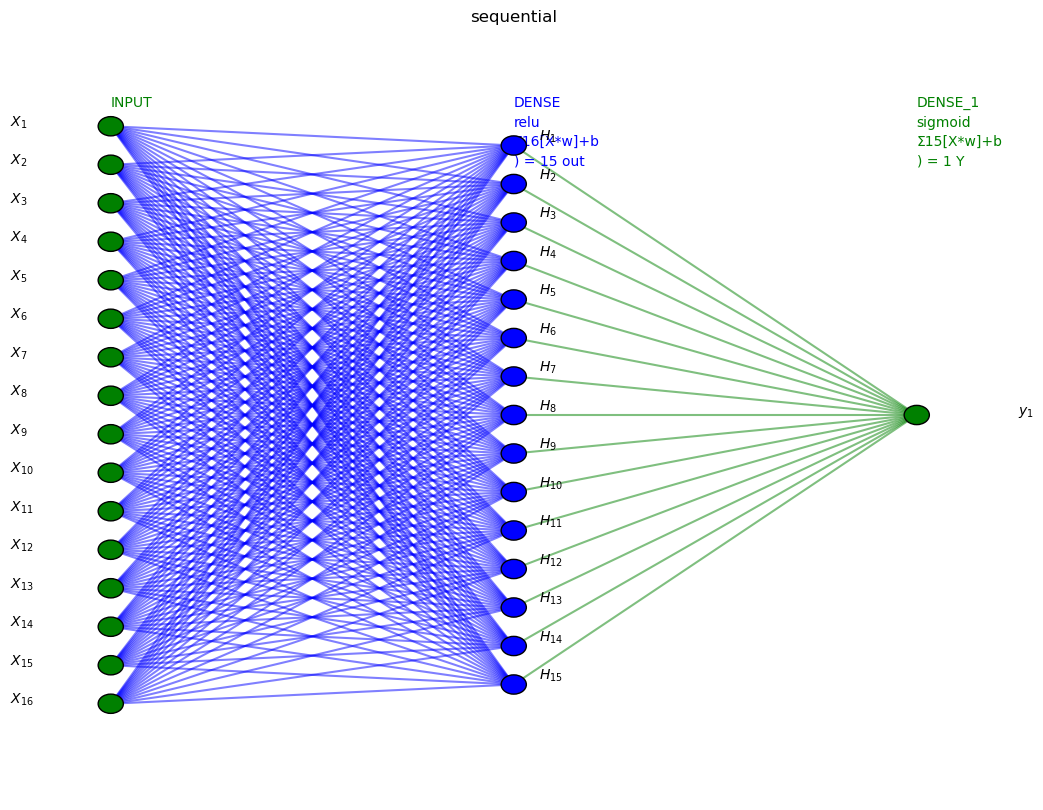

In [33]:
# # Define input neurons
# input_dimension = X_train_pca.shape[1]

# # Build and compile the basic neural network
# basic_model = build_basic_model(input_dimension, first_layer_neurons=15)

# Define input neurons
input_dimension = X_train_pca.shape[1]  # Assuming X_train_pca is defined elsewhere

# Build and compile the basic model
basic_model = build_basic_model(input_dimension, first_layer_neurons=15)

In [34]:

# # Fit the model with tqdm callback for progress bar
# def train_model(model, X_train, X_test, epochs, batch_size):
#     history = model.fit(
#         X_train_pca, y_train,                   # input features and target variable
#         epochs=epochs,                            # number of epoch(forward + backward propagation) to train the model
#         batch_size=batch_size,                  # size of the data batch during training
#         validation_data=(X_test_pca, y_test),   # validation data for monitoring performance during training
#         callbacks=[TqdmCallback(verbose=1)]     # using tqdm to display a progress bar
#     )

#     return history

# My code
def train_model(model, X_train, X_test, epochs, batch_size):
    history = model.fit(
        X_train_pca, y_train, # Input features and target variable
        epochs=epochs,            # Number of epochs to train the model
        batch_size=batch_size,        # Size of each batch during training
        validation_data=(X_test_pca, y_test), # Validation data for monitoring performance during training
        callbacks=[TqdmCallback(verbose=1)] # Using tqdm callback for progress bar
    )
    
    return history

In [35]:
# Fit the model using the function
# history = train_model(basic_model, X_train_pca, X_test_pca, epochs=50, batch_size=32)
history = train_model(basic_model, X_train_pca, X_test_pca, epochs=50, batch_size=32)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
116/116 [==============================] - 1s 4ms/step - loss: -571826.1875 - accuracy: 0.0000e+00 - recall: 0.6591 - precision: 1.0000 - val_loss: -1271083.5000 - val_accuracy: 0.0000e+00 - val_recall: 0.8924 - val_precision: 1.0000
Epoch 2/50
116/116 [==============================] - 0s 1ms/step - loss: -1946476.5000 - accuracy: 0.0000e+00 - recall: 0.9552 - precision: 1.0000 - val_loss: -2741645.7500 - val_accuracy: 0.0000e+00 - val_recall: 0.9968 - val_precision: 1.0000
Epoch 3/50
116/116 [==============================] - 0s 1ms/step - loss: -3586839.0000 - accuracy: 0.0000e+00 - recall: 0.9989 - precision: 1.0000 - val_loss: -4582178.0000 - val_accuracy: 0.0000e+00 - val_recall: 0.9992 - val_precision: 1.0000
Epoch 4/50
116/116 [==============================] - 0s 1ms/step - loss: -5656368.0000 - accuracy: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - val_loss: -6902232.0000 - val_accuracy: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/50
116/11

In [36]:
# Plot the training and validation accuracy over epochs
plot_history(history, metric='accuracy')

In [37]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4944, 21)
Shape of y: (4944,)


In [38]:
# Verify shapes after data splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify shapes after PCA transformation
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

X_train shape: (3708, 21)
X_test shape: (1236, 21)
y_train shape: (3708,)
y_test shape: (1236,)
X_train_pca shape: (3708, 16)
X_test_pca shape: (1236, 16)
